In [1]:
pip install music21 keras numpy midi2audio


In [2]:
import glob
from music21 import converter, instrument, note, chord

notes = []

for file in glob.glob("music_midi_dataset/*.mid"):
    midi = converter.parse(file)
    parts = instrument.partitionByInstrument(midi)
    elements = parts.parts[0].recurse() if parts else midi.flat.notes

    for e in elements:
        if isinstance(e, note.Note):
            notes.append(str(e.pitch))
        elif isinstance(e, chord.Chord):
            notes.append('.'.join(str(n) for n in e.normalOrder))


In [5]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# 🔢 Example input — replace with your actual dataset
# Could be genomic sequences, characters, musical notes, etc.
raw_data = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'A', 'B', 'C', 'D']

# ✅ Sanity check: must not be empty
if not raw_data:
    raise ValueError("Input data is empty. Provide a non-empty dataset.")

# 🎛️ Encode labels numerically
encoder = LabelEncoder()
encoded_data = encoder.fit_transform(raw_data)

# 🧮 Vocabulary size
n_vocab = len(set(encoded_data))

# 🧱 Sequence length for input chunks
sequence_length = 5

# 🏗️ Build input/output sequences
network_input = []
network_output = []

for i in range(0, len(encoded_data) - sequence_length):
    seq_in = encoded_data[i:i + sequence_length]
    seq_out = encoded_data[i + sequence_length]
    network_input.append(seq_in)
    network_output.append(seq_out)

# ⚠️ Check output is not empty before reshaping
if not network_output:
    raise ValueError("network_output is empty. Check sequence slicing logic.")

# 📐 Final shaping
network_input = np.reshape(network_input, (len(network_input), sequence_length, 1)) / float(n_vocab)
network_output = to_categorical(network_output, num_classes=n_vocab)

# 🖨️ Optional: confirm dimensions
print("network_input shape:", network_input.shape)
print("network_output shape:", network_output.shape)


network_input shape: (6, 5, 1)
network_output shape: (6, 7)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

model = Sequential()

# 🔁 LSTM layer for sequence learning
model.add(LSTM(128, input_shape=(network_input.shape[1], network_input.shape[2]), return_sequences=True))
model.add(Dropout(0.3))

# 🧠 Second LSTM layer
model.add(LSTM(128))
model.add(Dropout(0.3))

# 🎯 Output layer
model.add(Dense(n_vocab, activation='softmax'))

# 🛠️ Compile it
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 📜 Model summary (optional but informative)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,047 (777.53 KB)

 Trainable params: 199,047 (777.53 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 🔁 Train the model (you can increase epochs later)
model.fit(network_input, network_output, epochs=50, batch_size=64)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.0000e+00 - loss: 1.9461
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.0000e+00 - loss: 1.9417
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0000e+00 - loss: 1.9403
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.0000e+00 - loss: 1.9383
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.0000e+00 - loss: 1.9349
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3333 - loss: 1.9131
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1667 - loss: 1.9194
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1667 - loss: 1.9151
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3333 - loss: 1.9046
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1667 - loss: 1.9058
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.1667 - loss: 1.8971
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.16

In [8]:
import random

# 🧩 Choose a seed sequence from the training input
start_index = random.randint(0, len(network_input) - 1)
pattern = network_input[start_index]
pattern = np.reshape(pattern, (1, sequence_length, 1))

# 🔮 Predict the next step
prediction = model.predict(pattern, verbose=0)
index = np.argmax(prediction)

# 🧠 Convert back to original label
result = encoder.inverse_transform([index])
print("Next predicted symbol:", result[0])


Next predicted symbol: A


In [9]:
generated = []
pattern = network_input[start_index]

for i in range(100):
    prediction = model.predict(np.reshape(pattern, (1, sequence_length, 1)), verbose=0)
    index = np.argmax(prediction)
    result = encoder.inverse_transform([index])
    generated.append(result[0])

    # Update the input pattern
    new_input = np.append(pattern[1:], [[index]], axis=0)
    pattern = new_input

print("Generated sequence:")
print(generated)


Generated sequence:
[np.str_('A'), np.str_('B'), np.str_('D'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('C'), np.str_('C'), np.str_('B'), np.str_('B'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('B'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'), np.str_('C'),

In [10]:
# Evaluate accuracy and loss
loss, accuracy = model.evaluate(network_input, network_output)
print(f"Training Accuracy: {accuracy:.4f}")
print(f"Training Loss: {loss:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step - accuracy: 0.3333 - loss: 1.4267
Training Accuracy: 0.3333
Training Loss: 1.4267


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.2500 - loss: 1.6228 - val_accuracy: 0.5000 - val_loss: 1.1863
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.2500 - loss: 1.5631 - val_accuracy: 0.5000 - val_loss: 1.2376
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5000 - loss: 1.4319 - val_accuracy: 0.0000e+00 - val_loss: 1.3397
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.2500 - loss: 1.4067 - val_accuracy: 0.0000e+00 - val_loss: 1.5038
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.2500 - loss: 1.4217 - val_accuracy: 0.0000e+00 - val_loss: 1.7468
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7500 - loss: 1.2677 - val_accuracy: 0.0000e+00 - val_loss: 2.0817
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 1.0000 - loss: 1.0836 - val_accuracy: 0.0000e+00 - val_loss: 2.5242
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.5000 - loss: 1.2735 - val_accuracy

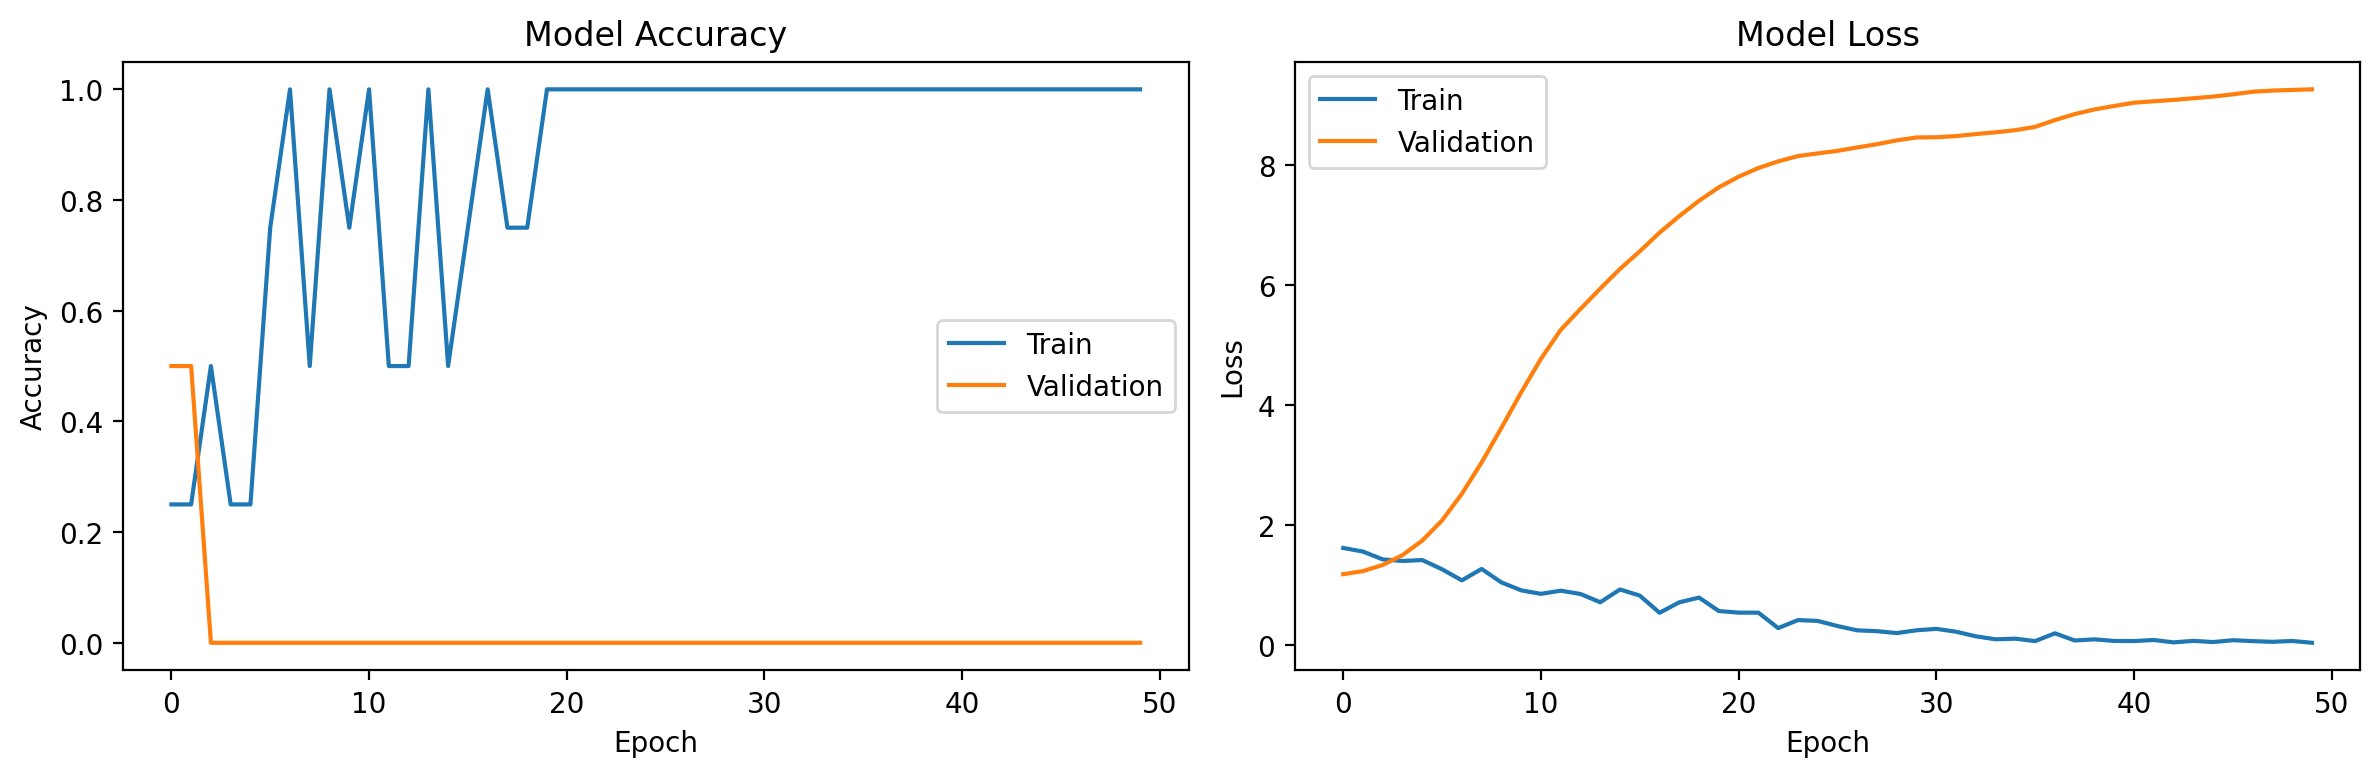

In [11]:
# Track training history
history = model.fit(network_input, network_output, epochs=50, batch_size=64, validation_split=0.2)

# Plot accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
# Save the trained model
model.save("sequence_model.keras")


In [14]:
decoded = encoder.inverse_transform(np.argmax(network_output, axis=1))
print("Decoded Output:", decoded[:20])  # View first 20 outputs


Decoded Output: ['F' 'G' 'A' 'B' 'C' 'D']


In [15]:
from collections import Counter
print(Counter(decoded))


Counter({np.str_('F'): 1, np.str_('G'): 1, np.str_('A'): 1, np.str_('B'): 1, np.str_('C'): 1, np.str_('D'): 1})


In [16]:
def sample_with_temperature(preds, temperature=1.0):
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)

# Generate with temperature control
generated = []
pattern = network_input[start_index]

for _ in range(100):
    prediction = model.predict(np.reshape(pattern, (1, sequence_length, 1)), verbose=0)[0]
    index = sample_with_temperature(prediction, temperature=0.8)
    result = encoder.inverse_transform([index])
    generated.append(result[0])

    # Update pattern
    pattern = np.append(pattern[1:], [[index]], axis=0)

print("Creative generated sequence:")
print(generated)


Creative generated sequence:
[np.str_('G'), np.str_('A'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('A'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('A'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('A'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('A'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('A'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('A'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('A'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('A'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('A'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('A'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('A'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('A'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('B'), np.str_('G'), np.str_('B'), np.str_('B'), np.s

In [17]:
import pandas as pd

df = pd.DataFrame({'Generated_Sequence': generated})
df.to_csv('generated_sequence.csv', index=False)
print("Saved sequence to generated_sequence.csv")


Saved sequence to generated_sequence.csv
